In [1]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from joblib import delayed,Parallel
from itertools import combinations
from functools import partial
import numpy as np
import gc
import pickle
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
timestamp = time()

In [2]:
###Functions
def timer(timestamp):
    #Timer Function
    print("time =", time()-timestamp)
    return

def fin_string(ns,s): #ns = length of string s = operator
    #Max string length
    if ns>L:
        ns=L
    else:
        pass
    
    
    def linears(start,m):
        #Find all indices in string
        ind=[i%L for i in range(start,start+ns)]
     #All combinations
        perm=list(combinations(ind,m))
      #Add each coupling to operator
        for j in range(len(perm)):
#            S_temp=[((-1)**m)*(2**m)/(L*(2**ns))] ########### Down #
            S_temp=[1/(L*(2**ns))] ###################### Up
            for i in range(len(perm[j])):
                S_temp.append(perm[j][i])
        ##Saving Couplin gs lists
            if j==0: 
                S_temp_2=[S_temp]
            else: 
                S_temp_2.append(S_temp)
        return S_temp_2
    #List to store orders of interaction
    o_type=np.empty(ns,dtype=object)
    
    for i in range(ns):
        #ex: "z"*2= "zz"
        o_type[i]=s*(i+1)

    #Iterate over each Site
    for k in range(L):
        #Iterate over different string lengths
      for i in range(ns):
          #First item defines list
          if k==0 and i==0:
              #example: i = 0 operator_list = [['x', linears(k,1)]]
              operator_list=[[o_type[i],linears(k,i+1)]]
          else:
              operator_list.append([o_type[i],linears(k,i+1)])
    S_temp_1 = [[(1/((ns*2**ns))), i] for i in range(ns)]
    #S_temp_1 = [[(1/((ns*2**(ns)))), 1] ]
    operator_list.append(["I",S_temp_1])
    operator_dict=dict(S=operator_list)
    O = quantum_operator(operator_dict,basis=basis,check_symm=False,check_herm=False)
    return O, operator_list

In [3]:
###### Model parameters

#Length of chain
L = 10
#X fields
J1 = 1 #NN term 
J2 = 0 #NNN Term
#Initial z field strength
h0 = 0 
#Final z fields
h_i,dh = np.linspace(0,5.5,100,retstep=True)

#Time
times,dt=np.linspace(0.0,50,1000,retstep=True)
#Basis being projected
op = "x"

In [4]:
###Using Quantum_Operator to build hamitlonian 
timestamp = time()
basis = spin_basis_1d(L, pauli = -1)


#NN Sigma x term (Periodic Boundary Conditions)
NN_sigma_x = [ [-J1, i, (i+1)%L] for i in range(L)]
#NNN Sigma x term (PBC)
NNN_sigma_x = [ [-J2,i, (i+2)%L] for i in range(L)]
#site coupling lists
sigma_z = [ [1, i] for i in range(L)]
#Define the static H (that doesn't change)
static_H = [ ["xx", NN_sigma_x], ["xx", NNN_sigma_x] ] 
#The z field is the quench
Quenching_H = [["z", sigma_z]]
#Define operator dictionary
operator_dict = dict(H0= static_H, Quench = Quenching_H)
#Build Hamiltonian
H = quantum_operator(operator_dict, basis=basis, check_herm= False, check_symm = False);
#Define Parameters
params_dict = dict( H0=1, Quench=0)
#Build H0
H0 = H.tohamiltonian(params_dict);
#Find eigenvalues
E,V = np.linalg.eigh(H0.todense())
#Convert matrix to array
V = np.array(V)
#Ground state of unquenched hamiltonian
V0= V[:,0]
D = len(V0)

#Build Projectors
Projectors = [fin_string(i,op)[0] for i in range(1,L+1)]


In [5]:
#Expectations of Projections (Sanity Checks)
Expt_Pi =[]
intial_state_overlap=[]
for hi in h_i:
    params_dict = dict(H0=1, Quench=hi)
    Hi = H.tohamiltonian(params_dict)
    E,V = np.linalg.eigh(Hi.todense())

    V = np.array(V)

    #Ground state
    Vi = V[:,0]

    expectations = [P.expt_value(Vi) for P in Projectors]

    Expt_Pi.append(expectations)
    intial_state_overlap.append(np.abs(V0@Vi)**2)

Expt_Pi = np.array(Expt_Pi)


/tmp/ipykernel_2897/3622298540.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0,1)


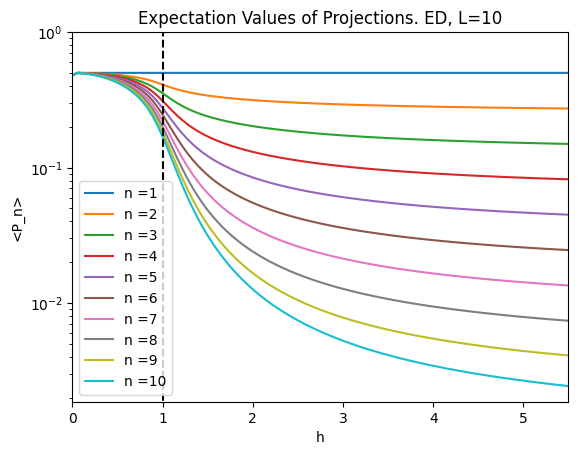

In [68]:
for n in range(0,L):
    plt.plot(h_i,Expt_Pi[:,n],label="n ="+str(n+1))

plt.legend()
plt.yscale("log")
plt.ylim(0.0,1)
plt.xlim(0,h_i[-1])
plt.xlabel("h")
plt.ylabel("<P_n>")
plt.title("Expectation Values of Projections. ED, L=10")
plt.plot(figsize=(600,500))
plt.vlines(1,0,1,color="black",linestyle="--")

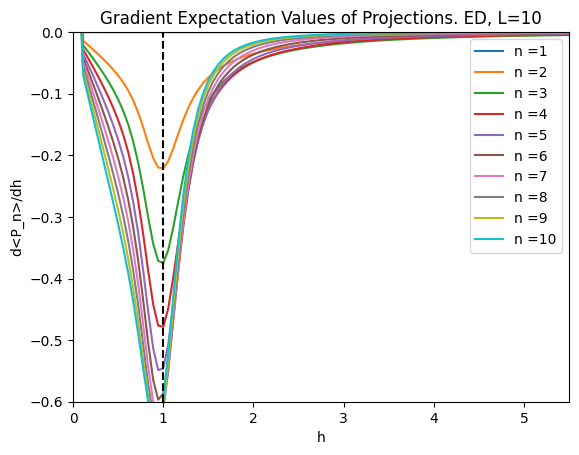

In [69]:
for n in range(0,L):
    plt.plot(h_i,np.gradient(Expt_Pi[:,n],h_i),label="n ="+str(n+1))

plt.legend()
#plt.yscale("log")
plt.ylim(-0.6,0)
plt.xlim(0,h_i[-1])
plt.xlabel("h")
plt.ylabel("d<P_n>/dh")
plt.title("Gradient Expectation Values of Projections. ED, L=10")
plt.plot(figsize=(600,500))
plt.vlines(1,-.6,0,color="black",linestyle="--")


[]

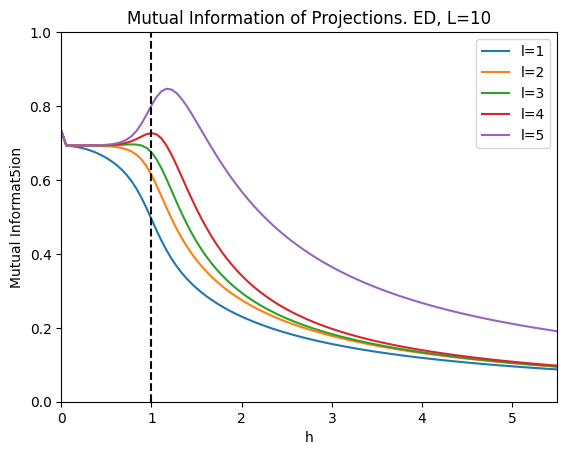

In [70]:
#plt.plot(h_i,np.log(Data[:,1]/Data[:,0]**2),label="l = 1")
mutual_info_l = [np.log(Expt_Pi[:,2*i-1]/Expt_Pi[:,i-1]**2) for i in range(1,L//2+1)]
mutual_info_l[1]
for i in range(0,L//2):
    plt.plot(h_i,mutual_info_l[i],label="l="+ str(i+1))
plt.vlines(1,0,1,color="black",linestyle="--")
plt.xlim((0,h_i[-1]))
plt.ylim((0,1))
plt.legend()
plt.xlabel("h")
plt.ylabel("Mutual Informat5ion")
plt.title("Mutual Information of Projections. ED, L=10")
plt.plot(figsize=(600,500))

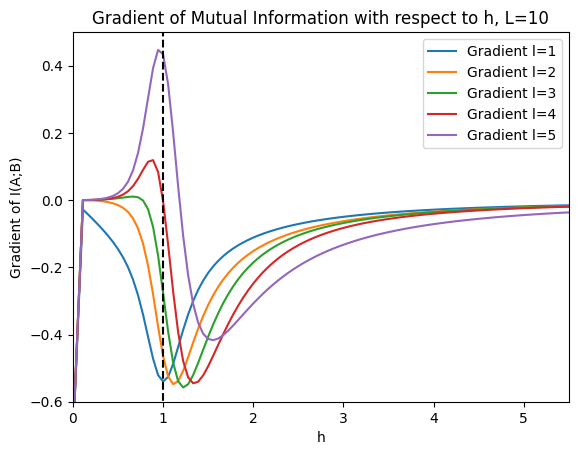

In [71]:
# Compute the gradient of mutual_info_l with respect to h_i using dh
gradient_mutual_info = [np.gradient(info.real, dh) for info in mutual_info_l]

# Plot the gradient for each l
for i, grad in enumerate(gradient_mutual_info):
    plt.plot(h_i, grad, label=f"Gradient l={i+1}")

plt.xlabel("h")
plt.ylabel("Gradient of I(A;B)")
plt.legend()
plt.title("Gradient of Mutual Information with respect to h, L=10")
plt.vlines(1,-1,1, colors='black',linestyle='dashed')
plt.xlim((0,h_i[-1]))
plt.ylim((-.6,.5))
plt.legend()
plt.show()

In [ ]:

# Evolved_states =[]

# # Loop over quench parameters
# for h in h_i:
#     # Update Hamiltonian with current parameters
#     params_dict = {'H0': 1, 'Quench': h}
#     H_i = H.tohamiltonian(params_dict)
    
#     # Diagonalize the Hamiltonian to get eigenvalues and eigenvectors
#     E, V = np.linalg.eigh(H_i.todense())
#     V = np.array(V)
    
#     # Compute time evolution of the initial state
#     psi1_time = ED_state_vs_time(V0, E, V, times, iterate=False)

#     Evolved_states.append(psi1_time)

In [74]:
# Dat =[]
# for hi in range(len(h_i)):
 
#     Pi = 0
#     for i in range(len(times)):
#         pt = Evolved_states[hi][:,i]
#         Pi += np.array([Projectors[i].expt_value(pt)/len(times) for i in range(0,10)])


#     Dat.append(Pi)
 

In [75]:
# I1 = [np.log( Dat[i][1]/Dat[i][0]**2) for i in range(len(h_i))]
# I2 = [np.log( Dat[i][3]/Dat[i][1]**2) for i in range(len(h_i))]
# I3 = [np.log( Dat[i][5]/Dat[i][2]**2) for i in range(len(h_i))]
# I4 = [np.log( Dat[i][7]/Dat[i][3]**2) for i in range(len(h_i))]
# I5 = [np.log( Dat[i][9]/Dat[i][4]**2) for i in range(len(h_i))]
# plt.plot(h_i,I1,label="l = 1")
# plt.plot(h_i,I2,label="l = 2")
# plt.plot(h_i,I3,label="l = 3")
# plt.plot(h_i,I4,label="l = 4")
# plt.plot(h_i,I5,label="l = 5")
# #plt.vlines(1,0,1,linestyle="dotted", color="black")
# plt.legend()
# plt.title("I(A;B) time averaged post quench. L = 10")
# plt.xlabel("h")
# plt.ylabel("I(A;B)")
# #plt.ylim(0,1)
# plt.xlim(0,h_i[-1])
# #plt.yscale("log")

In [6]:

def Thermal_Average(Op, E,V,beta):
    expt_values = np.array([Op.expt_value(V[:,i]) for i in range(len(E))])

    #Compute the probabilities
    p_i = np.exp(-beta*E)
    #Partition Function
    Z = np.sum(p_i)
    p_i /= Z
    return np.dot(p_i, expt_values)

In [7]:
#CALCULATE SPECTRUM
h_i = np.linspace(0,5,100)
betas = np.logspace(-2,np.log10(3),15)
#betas = np.logspace(-2,1,100)
Eigenvectors_hi =[]
Energies_hi = []
for hi in h_i:
    params_dict = dict(H0=1, Quench=hi)
    Hi = H.tohamiltonian(params_dict)
    E,V = np.linalg.eigh(Hi.todense())

    V = np.array(V)

    Eigenvectors_hi.append(V)
    Energies_hi.append(E)

n_1 = 1
n_2 = 2
n_3 = 3
n_4 = 4
n_5 = 5
n_6 = 6
n_7 = 7
n_8 = 8
n_9 = 9
n_10 = 10
#Projectors
OP1 = Projectors[n_1-1]
OP2 = Projectors[n_2-1]
OP3 = Projectors[n_3-1]
OP4 = Projectors[n_4-1]
OP5 = Projectors[n_5-1]
OP6 = Projectors[n_6-1]
OP7 = Projectors[n_7-1]
OP8 = Projectors[n_8-1]
OP9 = Projectors[n_9-1]
OP10 = Projectors[n_10-1]

In [12]:

P1_thermal = []
P2_thermal = []
P3_thermal = []
P4_thermal = []
P5_thermal = []
P6_thermal = []
P7_thermal = []
P8_thermal = []
P9_thermal = []
P10_thermal = []
for bi in betas:
    dat1  = []
    dat2  = []
    dat3  = []
    dat4  = []
    dat5  = []
    dat6  = []
    dat7  = []
    dat8  = []
    dat9  = []
    dat10 = []
    for hi in range(len(h_i)):
        dat1.append(Thermal_Average(OP1, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        dat2.append(Thermal_Average(OP2, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        dat3.append(Thermal_Average(OP3, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        dat4.append(Thermal_Average(OP4, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        dat5.append(Thermal_Average(OP5, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        dat6.append(Thermal_Average(OP6, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        # dat7.append(Thermal_Average(OP7, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        # dat8.append(Thermal_Average(OP8, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        # dat9.append(Thermal_Average(OP9, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        # dat10.append(Thermal_Average(OP10, Energies_hi[hi],Eigenvectors_hi[hi],bi))
        
    P1_thermal.append(dat1)
    P2_thermal.append(dat2)
    P3_thermal.append(dat3)
    P4_thermal.append(dat4)
    P5_thermal.append(dat5)
    P6_thermal.append(dat6)


    P7_thermal.append(dat5)
    P8_thermal.append(dat6)
    P9_thermal.append(dat5)
    P10_thermal.append(dat6)
    




/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Beta = 3.0')

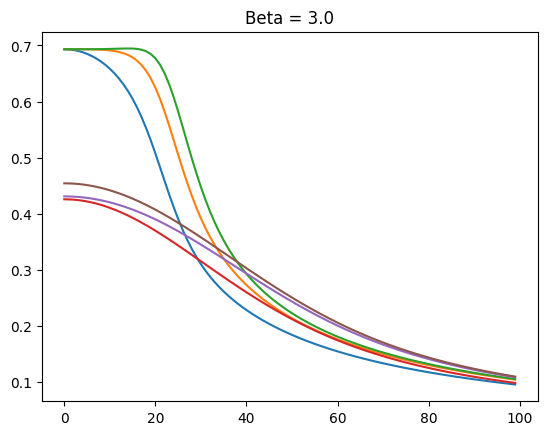

In [13]:
P1_thermal = np.array(P1_thermal)
P2_thermal = np.array(P2_thermal)
P3_thermal = np.array(P3_thermal)
P4_thermal = np.array(P4_thermal)
P5_thermal = np.array(P5_thermal)
P6_thermal = np.array(P6_thermal)
P7_thermal = np.array(P7_thermal)
P8_thermal = np.array(P8_thermal)
P9_thermal = np.array(P9_thermal)
P10_thermal = np.array(P10_thermal)

i = -1
j = 10
plt.plot(np.log(P2_thermal[i]/P1_thermal[i]**2))

plt.plot(np.log(P4_thermal[i]/P2_thermal[i]**2))
plt.plot(np.log(P6_thermal[i]/P3_thermal[i]**2))
plt.title("Beta = "+ str(betas[i]))

plt.plot(np.log(P2_thermal[j]/P1_thermal[j]**2))

plt.plot(np.log(P4_thermal[j]/P2_thermal[j]**2))
plt.plot(np.log(P6_thermal[j]/P3_thermal[j]**2))
plt.title("Beta = "+ str(betas[i]))

In [13]:
betas = np.linspace(0,3,20)


In [9]:
def thermal_averages(Op, Es, Vs, betas):
    Es = np.array(Es)  # shape (D,)
    Vs = np.array(Vs)  # shape (D,D)

    psi_Op_psi = np.array([Op.expt_value(Vs[:, i]) for i in range(Vs.shape[1])])  # shape (D,)

    E_beta = np.outer(betas, Es)  # shape (len(betas), D)
    weights = np.exp(-E_beta)
    Z = np.sum(weights, axis=1)  # shape (len(betas),)
    p_i = weights / Z[:, None]   # shape (len(betas), D)

    avg = np.dot(p_i, psi_Op_psi)  # shape (len(betas),)
    return avg


In [22]:
expt_1 = []
expt_2 = []
expt_3 = []
expt_4 = []
expt_5 = []
expt_6 = []
expt_7 = []
expt_8 = []
expt_9 = []
expt_10 = []
mutinfo_1 = []
mutinfo_2 = []
mutinfo_3 = []
mutinfo_4 = []
mutinfo_5 = []
for i in range(len(h_i)):
    Ei = Energies_hi[i]
    Vi = Eigenvectors_hi[i]

    vals1 = thermal_averages(OP1, Ei, Vi, betas)
    vals2 = thermal_averages(OP2, Ei, Vi, betas)
    vals3 = thermal_averages(OP3, Ei, Vi, betas)
    vals4 = thermal_averages(OP4, Ei, Vi, betas)
    vals5 = thermal_averages(OP5, Ei, Vi, betas)
    vals6 = thermal_averages(OP6, Ei, Vi, betas)
    # vals7 = thermal_averages(OP7, Ei, Vi, betas)
    # vals8 = thermal_averages(OP8, Ei, Vi, betas)
    # vals9 = thermal_averages(OP9, Ei, Vi, betas)
    # vals10 = thermal_averages(OP10, Ei, Vi, betas)


    # log_vals = np.log(vals2 / (vals1 ** 2))
    # log_vals2 = np.log(vals4 / (vals2 ** 2))
    # log_vals3 = np.log(vals6/ (vals3 ** 2))
    # log_vals4 = np.log(vals8 / (vals4 ** 2))
    # log_vals5 = np.log(vals10 / (vals5 ** 2))
    expt_1.append(vals1)
    expt_2.append(vals2)
    expt_3.append(vals3)
    expt_4.append(vals4)
    expt_5.append(vals5)
    expt_6.append(vals6)
    # expt_7.append(vals7)
    # expt_8.append(vals8)
    # expt_9.append(vals9)
    # expt_10.append(vals10)
    # mutinfo_1.append(log_vals)
    # mutinfo_2.append(log_vals2)
    # mutinfo_3.append(log_vals3)
    # mutinfo_4.append(log_vals4)
    # mutinfo_5.append(log_vals5)

plt.plot(betas,expt_1)

5.0


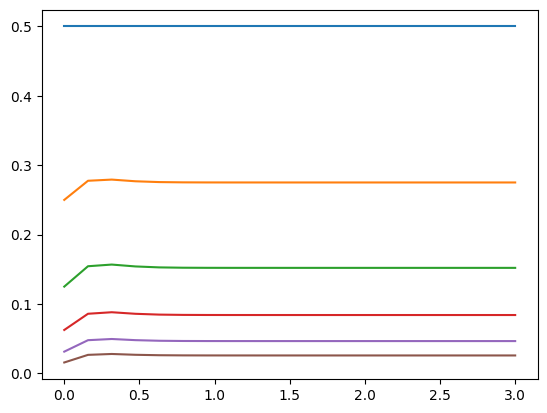

In [ ]:
i = -1
print(h_i[-1])
plt.plot(betas,expt_1[i])
plt.plot(betas,expt_2[i])
plt.plot(betas,expt_3[i])
plt.plot(betas,expt_4[i])
plt.plot(betas,expt_5[i])
plt.plot(betas,expt_6[i])
plt.xlabel("BETA")

/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 2.99)

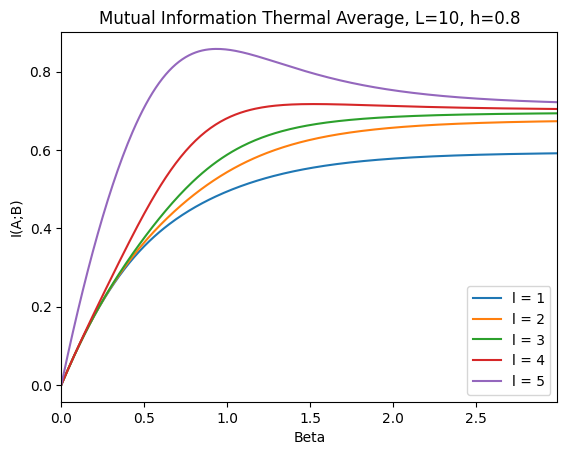

In [21]:
i =0
plt.plot(betas,mutinfo_1[i],label= "l = 1")
plt.plot(betas,mutinfo_2[i],label= "l = 2")
plt.plot(betas,mutinfo_3[i],label= "l = 3")
plt.plot(betas,mutinfo_4[i],label= "l = 4")
plt.plot(betas,mutinfo_5[i],label= "l = 5")

plt.legend()
plt.xlabel("Beta")
plt.ylabel("I(A;B)")
plt.title("Mutual Information Thermal Average, L=10, h="+str(h_i[i])) 
plt.xlim(betas[0],betas[-1])

(0.0, 2.99)

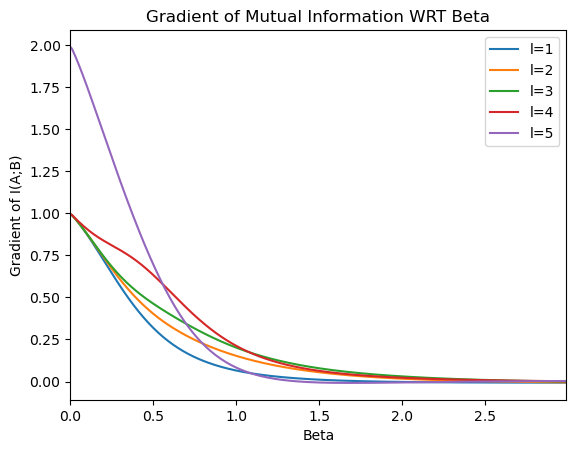

In [516]:

plt.plot(betas,np.gradient(mutinfo_1[i],betas),label="l=1")
plt.plot(betas,np.gradient(mutinfo_2[i],betas),label="l=2")
plt.plot(betas,np.gradient(mutinfo_3[i],betas),label="l=3")
plt.plot(betas,np.gradient(mutinfo_4[i],betas),label="l=4")
plt.plot(betas,np.gradient(mutinfo_5[i],betas),label="l=5")

plt.legend()
plt.title("Gradient of Mutual Information WRT Beta")
plt.xlabel("Beta")
plt.ylabel("Gradient of I(A;B)")
plt.xlim((0,betas[-1]))



Text(0, 0.5, '<P_n>_th')

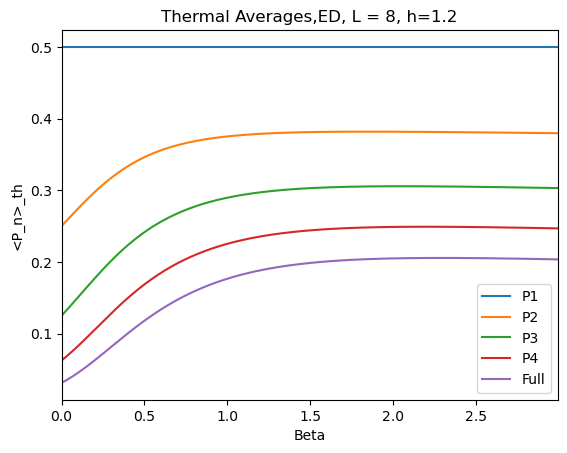

In [504]:
i = -1
plt.plot(betas,expt_1[i],label= f"P1"[0:3])
plt.plot(betas,expt_2[i],label= f"P2"[0:3])
plt.plot(betas,expt_3[i],label= f"P3"[0:3])
plt.plot(betas,expt_4[i],label= f"P4"[0:3])
plt.plot(betas,expt_5[i],label= f"Full")
    #plt.plot(betas,data4[i],label= f"{h_i[i]}"[0:3], linestyle="dotted")

plt.legend()
plt.xlim((betas[0],betas[-1]))
plt.title("Thermal Averages,ED, L = 8, h=" + str(h_i[i]))
#plt.ylim( (0,.55))
plt.xlabel("Beta")
plt.ylabel(f"<P_n>_th")


In [11]:
expt_1 = []
expt_2 = []
expt_3 = []
expt_4 = []
expt_5 = []
expt_6 = []
expt_7 = []
expt_8 = []
expt_9 = []
expt_10 = []
mutinfo_1 = []
mutinfo_2 = []
mutinfo_3 = []
mutinfo_4 = []
mutinfo_5 = []
for i in range(len(h_i)):
    Ei = Energies_hi[i]
    Vi = Eigenvectors_hi[i]

    vals1 = thermal_averages(OP1, Ei, Vi, betas)
    vals2 = thermal_averages(OP2, Ei, Vi, betas)
    vals3 = thermal_averages(OP3, Ei, Vi, betas)
    vals4 = thermal_averages(OP4, Ei, Vi, betas)
    vals5 = thermal_averages(OP5, Ei, Vi, betas)
    vals6 = thermal_averages(OP6, Ei, Vi, betas)
    vals7 = thermal_averages(OP7, Ei, Vi, betas)
    vals8 = thermal_averages(OP8, Ei, Vi, betas)
    vals9 = thermal_averages(OP9, Ei, Vi, betas)
    vals10 = thermal_averages(OP10, Ei, Vi, betas)


    log_vals = np.log(vals2 / (vals1 ** 2))
    log_vals2 = np.log(vals4 / (vals2 ** 2))
    log_vals3 = np.log(vals6/ (vals3 ** 2))
    log_vals4 = np.log(vals8 / (vals4 ** 2))
    log_vals5 = np.log(vals10 / (vals5 ** 2))
    expt_1.append(vals1)
    expt_2.append(vals2)
    expt_3.append(vals3)
    expt_4.append(vals4)
    expt_5.append(vals5)
    expt_6.append(vals6)
    expt_7.append(vals7)
    expt_8.append(vals8)
    expt_9.append(vals9)
    expt_10.append(vals10)
    mutinfo_1.append(log_vals)
    mutinfo_2.append(log_vals2)
    mutinfo_3.append(log_vals3)
    mutinfo_4.append(log_vals4)
    mutinfo_5.append(log_vals5)

KeyboardInterrupt: 

In [45]:

def read_thermal_data(filename):
    """
    Read the projector data from a file and return the x values and data as a numpy array.
    
    Parameters:
    filename (str): The path to the file containing the projector data.
    
    Returns:
    tuple: A tuple containing the x values and the data as a numpy array.
    """
    with open(filename) as f:
        lines = f.readlines()

    b_vals = [float(val) for val in lines[0].strip().split('\t')]
    h_vals = [float(val) for val in lines[1].strip().split('\t')]

    data_list = []
    for line in lines[2:]:
        formatted_line = line.strip().replace("im", "j")
        data_array = np.array([complex(val.replace(" ", "")) for val in formatted_line.split('\t')])
        data_list.append(data_array)

    return b_vals,h_vals, data_list

P1_a = "../../../results/thermal_averages/L=10_n=1_TFIM_thermal_average.txt"
P2_a = "../../../results/thermal_averages/L=10_n=2_TFIM_thermal_average.txt"
P3_a = "../../../results/thermal_averages/L=10_n=3_TFIM_thermal_average.txt"
P4_a = "../../../results/thermal_averages/L=10_n=4_TFIM_thermal_average.txt"
P5_a = "../../../results/thermal_averages/L=10_n=5_TFIM_thermal_average.txt"
P6_a = "../../../results/thermal_averages/L=10_n=6_TFIM_thermal_average.txt"
#P1_a = "../../../results/thermal_averages/L=10_n=3_TFIM_thermal_average.txt"

b,h,P1_a = read_thermal_data(P1_a)
b,h,P2_a = read_thermal_data(P2_a)
b,h,P3_a = read_thermal_data(P3_a)
b,h,P4_a = read_thermal_data(P4_a)
b,h,P5_a = read_thermal_data(P5_a)
b,h,P6_a = read_thermal_data(P6_a)

In [56]:
P_a = [[],P1_a,P2_a,P3_a,P4_a,P5_a,P6_a]
P_ED = [[],P1_thermal,P2_thermal,P3_thermal,P4_thermal,P5_thermal,P6_thermal]

/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/kristian/miniconda3/lib/python3.12/site-packages/matplotlib/collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


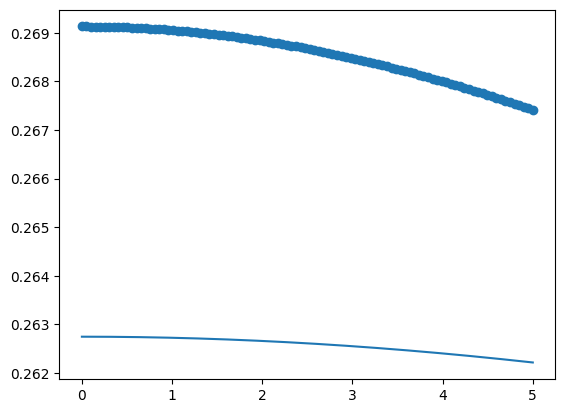

In [57]:
n = 2
i = 5
plt.plot(h,P_a[n][i-1],label = "beta = " + str(b[i])[:4])
plt.scatter(h_i,P_ED[n][i])

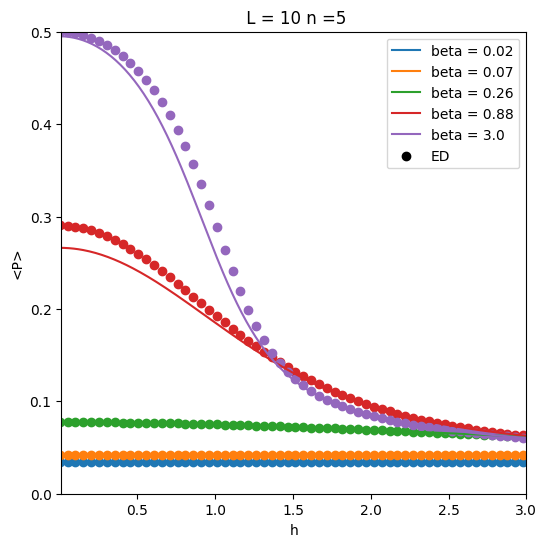

In [58]:
n = 5
plt.figure(figsize=(6,6))
for i in range(2,len(b),3):
    plt.plot(h,P_a[n][i],label = "beta = " + str(b[i])[:4])
    plt.scatter(h_i,P_ED[n][i])
plt.scatter([-5],[0],label = "ED",color = "black")
plt.legend()

plt.xlabel("h")
plt.ylabel("<P>")
plt.title(" L = " + str(L)+" n =" +str(n))
plt.xlim(b[0],b[-1])
plt.ylim(0,.5)
plt.legend()

#plt.savefig(f"figure_L{L}_N{n}.png")


IndexError: list index out of range

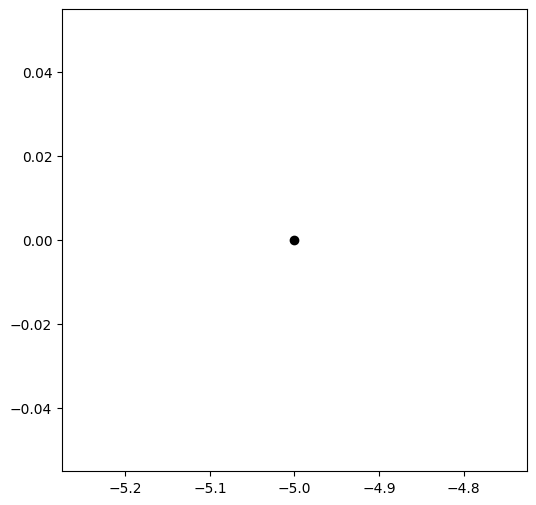

In [59]:
plt.figure(figsize=(6,6))

def mutual_info_processing(P_list,n_even,beta):
    n_sub = (n_even-1)//2
    return np.log(P_list[n_even-1][beta]/P_list[n_sub][beta]**2)
plt.scatter([-5],[0],label = "ED",color = "black")

n = 9
for bi in range(2,len(b),3):
    mut_info_analytic = mutual_info_processing(P_a,n,bi)
    mut_info_ED =       mutual_info_processing(P_ED,n,bi)

    plt.plot(h,mut_info_analytic,label = str(b[bi])[0:4])
    plt.scatter(h_i,mut_info_ED)
plt.xlabel("h")
plt.ylabel("<P2>")
plt.title(" L = " + str(L)+" l =" +str(n//2))
plt.xlim(b[0],b[-1])
plt.ylim(0,1)
plt.legend()
plt.savefig(f"mutualinfo_L{L}_l{n//2}.png")

plt.show()

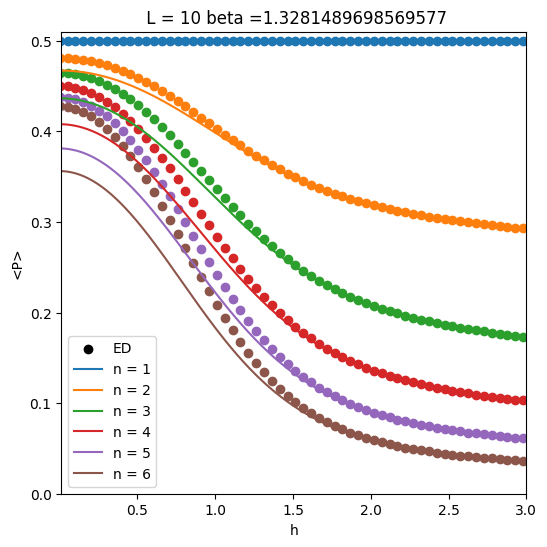

In [274]:
plt.figure(figsize=(6,6))

bi = -3
plt.scatter([-5],[0],label = "ED",color = "black")

for Pi in range(1,len(P_a)):
    plt.plot(h,P_a[Pi][bi],label = "n = " + str(Pi))
    plt.scatter(h_i,P_ED[Pi][bi-0])
plt.xlabel("h")
plt.ylabel("<P>")
plt.title(" L = " + str(L)+" beta =" +str(b[bi]))
plt.xlim(b[0],b[-1])
plt.ylim(0.0,.51)
plt.legend()
plt.savefig(f"projections_L{L}_beta{bi}.png")

plt.show()

In [85]:
len(b)

15

In [86]:
len(betas)

15